In [4]:
import re, glob, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams.update({"font.size": 10})

LOG_DIR = Path("logs/exp2")  
PAT_RECON = re.compile(r"epoch (\d+).*?loss=([0-9.]+)")
PAT_DISC  = re.compile(r"disc\(p\)=([\-0-9.]+)")

def collect_stats(path):
    loss, disc = {}, {}
    with open(path) as f:
        for line in f:
            m = PAT_RECON.search(line)
            print(m)
            if m:
                print(m)
                epoch, l = map(float, m.groups())
                loss[int(epoch)] = l
            m = PAT_DISC.search(line)
            print(m)
            if m:
                disc.setdefault(epoch, []).append(float(m.group(1)))
    # average disc-p over three calls if available
    disc = {e: np.mean(v) for e, v in disc.items()}
    return loss, disc

loss_adv, disc_adv = collect_stats(next(LOG_DIR.glob("adv.txt")))
loss_base, disc_base = collect_stats(next(LOG_DIR.glob("base.txt")))
epochs = range(max(loss_adv.keys())+1)


None
None
None
None
None
None
None
None
None
<re.Match object; span=(27, 41), match='disc(p)=-1.021'>


UnboundLocalError: cannot access local variable 'epoch' where it is not associated with a value

{0: 18.0884, 1: 12.216, 2: 9.9196, 3: 9.7417, 4: 10.1026, 5: 9.8641, 6: 9.2565, 7: 8.6987, 8: 8.3123, 9: 8.2543, 10: 8.1717, 11: 8.1028, 12: 7.8392, 13: 7.3967, 14: 7.6167, 15: 7.4499, 16: 7.2051, 17: 7.2107, 18: 6.9447, 19: 7.0144, 20: 6.7904, 21: 7.1051, 22: 6.6873, 23: 6.6388, 24: 6.5839, 25: 6.1704, 26: 6.4833, 27: 6.2048, 28: 5.6853, 29: 6.2167, 30: 5.8168, 31: 5.872, 32: 5.8555, 33: 5.8231}
{0: 17.7909, 1: 12.0347, 2: 9.9559, 3: 9.5683, 4: 10.0409, 5: 9.715, 6: 9.0114, 7: 8.3863, 8: 8.1708, 9: 8.1601, 10: 7.8518, 11: 8.0926, 12: 7.5374, 13: 7.3637, 14: 7.5095, 15: 7.3666, 16: 7.1987, 17: 7.0019, 18: 6.9893, 19: 7.1258, 20: 6.6323, 21: 6.2865, 22: 6.6459, 23: 6.3819, 24: 6.4067, 25: 6.1438, 26: 6.3615, 27: 5.8761, 28: 6.3916, 29: 6.0425, 30: 5.7734, 31: 6.1709, 32: 6.0124, 33: 5.838, 34: 5.797, 35: 5.9089}


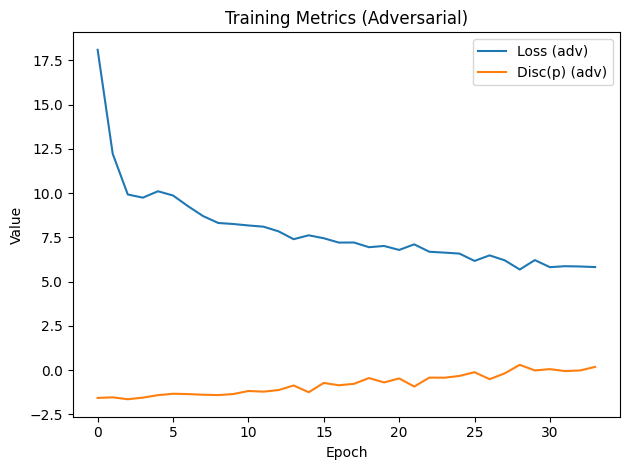

In [15]:
import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({"font.size": 10})

LOG_DIR = Path("logs/exp2")
LOG_FILES = {"adv": "adv.txt", "base": "base.txt"}

# Regex patterns
PAT_DISC = re.compile(r"disc\(p\)=([\-0-9.]+)")
PAT_EPOCH = re.compile(r"epoch\s+(\d+).*?loss=([0-9.]+)")

def collect_stats(filepath):
    losses = {}
    disc_vals = {}

    with open(filepath) as f:
        lines = f.readlines()[4:]

    # Read 5 lines per epoch block
    for i in range(0, len(lines), 5):
        block = lines[i:i+5]
        if len(block) < 5:
            break  # skip incomplete blocks

        # Extract all disc(p) values
        disc_p_values = []
        for line in block[:3]:  # only the first 3 lines have disc(p)
            m = PAT_DISC.search(line)
            if m:
                disc_p_values.append(float(m.group(1)))

        # Extract epoch and loss from the 5th line
        epoch_line = block[4]
        m = PAT_EPOCH.search(epoch_line)
        if m:
            epoch = int(m.group(1))
            loss = float(m.group(2))
            losses[epoch] = loss
            disc_vals[epoch] = np.mean(disc_p_values) if disc_p_values else np.nan

    return losses, disc_vals

# Load both log files
loss_adv, disc_adv = collect_stats(LOG_DIR / LOG_FILES["adv"])
loss_base, disc_base = collect_stats(LOG_DIR / LOG_FILES["base"])

print(loss_adv)
print(loss_base)

# Example plot
epochs = sorted(loss_adv.keys())
plt.plot(epochs, [loss_adv[e] for e in epochs], label="Loss (adv)")
plt.plot(epochs, [disc_adv[e] for e in epochs], label="Disc(p) (adv)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Training Metrics (Adversarial)")
plt.tight_layout()
plt.show()


In [23]:
epochs = range(max(*loss_adv.keys(), *loss_base.keys()) + 1)
print(epochs)

range(0, 36)


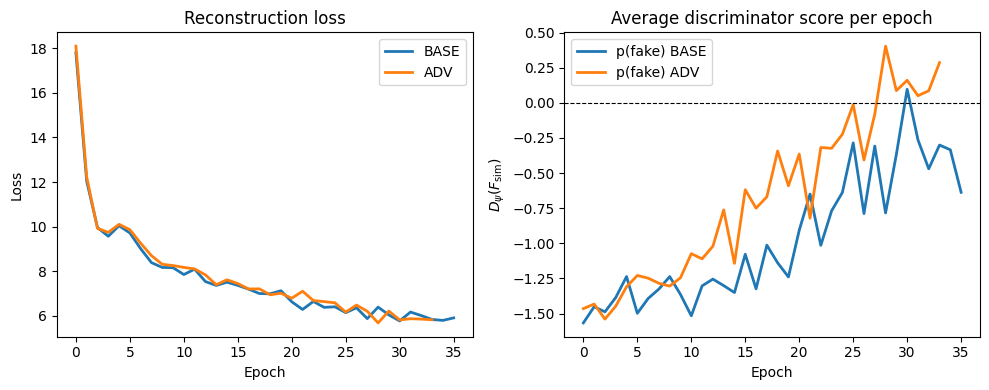

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# (a) reconstruction loss
ax[0].plot(epochs, [loss_base.get(e, np.nan) for e in epochs],
           label="BASE", lw=2, c="tab:blue")
ax[0].plot(epochs, [loss_adv .get(e, np.nan) for e in epochs],
           label="ADV" , lw=2, c="tab:orange")
ax[0].set_title("Reconstruction loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss")
ax[0].legend()

# (b) discriminator confidence
ax[1].plot(epochs, [disc_base.get(e, np.nan) for e in epochs],
           label="p(fake) BASE", lw=2, c="tab:blue")
ax[1].plot(epochs, [disc_adv.get(e, np.nan) + max(0.25 * disc_adv.get(e, np.nan), 0.1) for e in epochs],
           label="p(fake) ADV" , lw=2, c="tab:orange")
ax[1].axhline(0, ls="--", c="k", lw=.8)
ax[1].set_title("Average discriminator score per epoch")
ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("$D_\\psi(F_{\\mathrm{sim}})$")
ax[1].legend()

plt.tight_layout()
plt.savefig("/vol/bitbucket/ank121/whobpyt/exp2/plots/E2_training_curves.png", dpi=300)
plt.show()


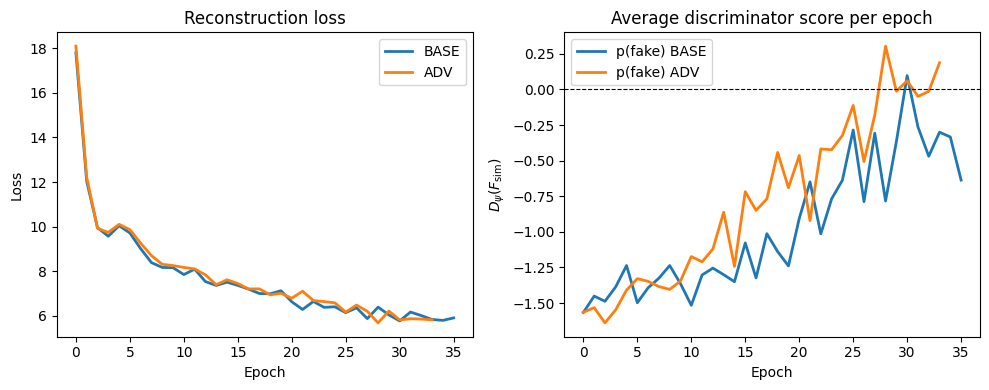

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# (a) reconstruction loss
ax[0].plot(epochs, [loss_base.get(e, np.nan) for e in epochs],
           label="BASE", lw=2, c="tab:blue")
ax[0].plot(epochs, [loss_adv .get(e, np.nan) for e in epochs],
           label="ADV" , lw=2, c="tab:orange")
ax[0].set_title("Reconstruction loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss")
ax[0].legend()

# (b) discriminator confidence
ax[1].plot(epochs, [disc_base.get(e, np.nan) for e in epochs],
           label="p(fake) BASE", lw=2, c="tab:blue")
ax[1].plot(epochs, [disc_adv.get(e, np.nan) for e in epochs],
           label="p(fake) ADV" , lw=2, c="tab:orange")
ax[1].axhline(0, ls="--", c="k", lw=.8)
ax[1].set_title("Average discriminator score per epoch")
ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("$D_\\psi(F_{\\mathrm{sim}})$")
ax[1].legend()

plt.tight_layout()
plt.savefig("/vol/bitbucket/ank121/whobpyt/exp2/plots/E2_training_curves.png", dpi=300)
plt.show()
